# Retry Backoff and Jitter

This notebook explores the topic of retries, backoff, and jitter through simulation. A lot of this
analysis is based off of the AWS Architecture Blog post
[Exponential Backoff And Jitter][aws-retries-blog-post] and the code from their
[`aws-arch-backoff-simulator`](https://github.com/aws-samples/aws-arch-backoff-simulator) code.

[aws-retries-blog-post]: https://aws.amazon.com/blogs/architecture/exponential-backoff-and-jitter/

## Running the Notebook

This notebook was authored using Visual Studio Code's integrated Jupyter Notebook support.

In order to explore the notebook interactively, you will need to set this up in Visual Studio Code.

### Creating the `research` Hatch Environment

To create the `research` hatch environment which contains additional dependencies, you can run:

```sh
hatch env create research
```

Next, we need to find the environment's file-system path:

```sh
hatch env find
```

Take note of this file path for the next section.

### Register the Hatch Environment Interpreter in Visual Studio Code

1.  Open the Command Pallette. This can be done using one of the following:

    *   The `View` &rarr; `Command Pallette...` menu bar, **or**
    *   The keyboard shortcuts

        | Platform | Default shortcut |
        | --- | --- |
        | Windows / Linux | `CTRL` + `SHIFT` + `P` |
        | MacOS | `CMD` + `SHIFT` + `P` |
2.  Type and select:

    ```
    Python: Select Interpreter
    ```
3.  Choose **Enter Interpreter path...**
4.  Choose **Find...**
5.  Paste the `research` hatch environment path from the previous section and append `/bin/python`
    to the end of the path.

### Setup the Notebook Kernel

Next, we need to configure a Notebook Kernel that uses the newly setup Visual Studio Code Python
interpreter in the previous section.

1.  Open up this notebook in Visual Studio Code.
2.  Open the Command Pallette
3.  Enter and select:

    ```
    Notebook: Select Notebook Kernel
    ```
4.  Click **Select Another Kernel...**
5.  Click **Python Envrionments...**
6.  Under the **Virtual Env** group of the listed Python environments, you should see the `research`
    interpreter. Select this one.

## Simulation Framework

We begin by defining a simulation framework. Below, we create a few types for this:

*   `EventType` an enumeration which currently only contains `REQUEST` and `RESPONSE` types
*   `Event` a representation of an event occurring within the simulation. Each event has a type,
    an attempt_number and a timestamp.
*   `Simulation` class. Accepts simulation parameters and can be instantiated to test variations
    of the simulation. This creates a heap to maintain an ordered collection of events.

In [1]:
from enum import Enum
from random import gauss, random, uniform
from typing import Callable, NamedTuple
import heapq

from botocore.retries.base import BaseRetryBackoff
from botocore.retries.standard import RetryContext


DEFAULT_MAX_BACKOFF = 30
DEFAULT_NUM_WORKERS = 200


def default_api_latency_random() -> float:
    return gauss(3.005757397, 1.028332678)


def default_worker_startup_random() -> float:
    return uniform(0, 5)


class EventType(Enum):
    REQUEST = 1
    RESPONSE = 2


class Event(NamedTuple):
    timestamp: float
    typ: EventType
    attempt: int


class Simulation:
    _api_latency_mean: float
    _api_latency_random: Callable[[], float]
    _api_latency_stddev: float
    _backoff: BaseRetryBackoff
    _events: list[Event]
    _num_workers: int
    _time: int
    _worker_startup_random: Callable[[], float]

    def __init__(
        self,
        *,
        backoff: BaseRetryBackoff,
        api_latency_random: Callable[[], float] = default_api_latency_random,
        num_workers: int = DEFAULT_NUM_WORKERS,
        worker_startup_random: Callable[[], float] = default_worker_startup_random,
    ) -> None:
        # Required
        self._backoff = backoff

        # Optional with defaults
        self._api_latency_random = api_latency_random
        self._num_workers = num_workers
        self._worker_startup_random = worker_startup_random

        self._events = self._initialize_events()
        self._time = 0

    def _initialize_events(self) -> list[Event]:
        events = [
            Event(
                timestamp=self._worker_startup_random(),
                typ=EventType.REQUEST,
                attempt=1,
            )
            for _ in range(self._num_workers)
        ]
        heapq.heapify(events)
        return events

    def tick(self) -> int:
        events = self._events

        self._time += 1

        request_count = 0

        while events and events[0].timestamp < self._time:
            event = heapq.heappop(events)
            if event.typ == EventType.REQUEST:
                # A request is scheduled for this time.

                # Track the request in its per-second bin
                request_count += 1

                # Calculate the latency based on mean and standard deviation
                latency = self._api_latency_random()

                # Calculate response time
                response_timestamp = event.timestamp + latency

                heapq.heappush(
                    events,
                    Event(
                        typ=EventType.RESPONSE,
                        attempt=event.attempt,
                        timestamp=response_timestamp,
                    ),
                )
            elif event.typ == EventType.RESPONSE:
                # A response was received. Queue up a retry event

                # Caculate the back-off delay
                next_attempt = event.attempt + 1
                retry_context = RetryContext(attempt_number=next_attempt)
                delay: float = self._backoff.delay_amount(retry_context)

                next_request_timestamp = event.timestamp + delay
                heapq.heappush(
                    events,
                    Event(
                        typ=EventType.REQUEST,
                        timestamp=next_request_timestamp,
                        attempt=next_attempt,
                    ),
                )

        return request_count

## Retry Algorithms (Backoff and Jitter)

Below are a few algorithms provided in [Exponential Backoff And Jitter][aws-retries-blog-post] blog
post:

[aws-retries-blog-post]: https://aws.amazon.com/blogs/architecture/exponential-backoff-and-jitter/

In [2]:
import math
import random

from botocore.retries.standard import (
    BaseRetryBackoff,
    ExponentialBackoff as BotocoreExponentialBackoff,
    RetryContext,
)


class DecorrelatedExponentialBackoff(BaseRetryBackoff):  # pragma: no cover
    """
    Decorreclated jitter:

        delay( i ) = min( max_backoff, rand( base, delay( i - 1 ) * 3 ) )

    where ``i`` is the request attempt (0 based).
    """

    _BASE: float = 0.1

    _last_delay: float
    _max_backoff: float

    _random_uniform: Callable[[float, float], float]

    def __init__(
        self,
        max_backoff: float = 20,
        random_uniform: Callable[[float, float], float] = random.uniform,
    ):
        self._max_backoff = max_backoff
        self._random_uniform = random_uniform
        self._base = self._BASE

        self._last_delay = self._base

    def delay_amount(
        self,
        context: RetryContext,
    ) -> float:
        self._last_delay = min(
            self._max_backoff,
            self._random_uniform(self._base, self._last_delay * 3),
        )
        return self._last_delay


class EqualJitterExponentialBackoff(BotocoreExponentialBackoff):  # pragma: no cover
    """Calculates delay using a parametric equation where half of the
    result is based on standard exponential backoff and the other half is
    randomly picked between 0 and half of the normal exponential backoff
    amount.

        t_i = base * 2 ** i
        delay( i ) = 0.5 * t_i + 0.5 * random( 0, 0.5 * t_i )

    where ``i`` is the request attempt (0 based).
    """

    _BASE = 0.2

    _log_val: float
    _random_uniform: Callable[[float, float], float]

    def __init__(
        self,
        max_backoff: float = 20,
        random_uniform: Callable[[float, float], float] = random.uniform,
    ):
        super().__init__(max_backoff)
        self._random_uniform = random_uniform

        self._log_val = math.log(max_backoff, 2)

    def delay_amount(self, context: RetryContext) -> float:
        # The context.attempt_number is a 1-based value, but we have
        # to calculate the delay based on i based a 0-based value.
        # We want the first delay to just be ``rand(0, 1)``.
        attempt_number = context.attempt_number - 1

        if attempt_number > self._log_val:
            temp = self._max_backoff
        else:
            temp = 2**attempt_number

        half_temp = temp * 0.5
        return half_temp + self._random_uniform(0, half_temp)


class FullJitterExponentialBackoff(BotocoreExponentialBackoff):  # pragma: no cover
    """Calculates delay based on exponential backoff.

    This class implements truncated binary exponential backoff
    with jitter::

        delay( i ) = rand( 0, 1 ) * min( base * 2 ** attempt, MAX_BACKOFF )

    where ``i`` is the request attempt (0 based).

    """

    _BASE = 0.2

    _log_val: float
    _random_uniform: Callable[[float, float], float]
    _half_max_backoff: float

    def __init__(
        self,
        max_backoff: float = 20,
        random: Callable[[], float] = random.random,
        random_uniform: Callable[[float, float], float] = random.uniform,
    ):
        super().__init__(max_backoff, random=random)
        self._random_uniform = random_uniform
        self._base = self._BASE
        self._half_max_backoff = max_backoff * 0.5
        self._log_val = math.log(max_backoff, 2)

    def delay_amount(self, context: RetryContext) -> float:
        # The context.attempt_number is a 1-based value, but we have
        # to calculate the delay based on i based a 0-based value.
        # We want the first delay to just be ``rand(0, 1)``.
        attempt_number = context.attempt_number - 1

        # return super(ExponentialBackoff, self).delay_amount(context)

        if attempt_number > self._log_val:
            return self._random_uniform(
                self._half_max_backoff,
                self._max_backoff,
            )
            # return (
            #     # 70% of the max back-off
            #     0.7 * self._max_backoff
            #     # + 30% of the max back-off of jitter'ed
            #     + 0.3 * self._random_uniform(self._max_backoff
            # )

        return self._random() * min(
            2**attempt_number,
            self._max_backoff,
        )

## Simulation Parametrizations

Next, we define the different parameters we'd like to run the solution over:

In [3]:
from botocore.retries.standard import ExponentialBackoff as BotoExponentialBackoff
from deadline_worker_agent.boto import NoOverflowExponentialBackoff

num_workers = 100000

simulations: dict[str, Simulation] = {
    "boto": Simulation(
        backoff=BotoExponentialBackoff(
            max_backoff=DEFAULT_MAX_BACKOFF,
        ),
        num_workers=num_workers,
    ),
    "decorrelated-jitter": Simulation(
        backoff=DecorrelatedExponentialBackoff(max_backoff=DEFAULT_MAX_BACKOFF),
        num_workers=num_workers,
    ),
    "equal-jitter": Simulation(
        backoff=EqualJitterExponentialBackoff(max_backoff=DEFAULT_MAX_BACKOFF),
        num_workers=num_workers,
    ),
    "full-jitter": Simulation(
        backoff=FullJitterExponentialBackoff(max_backoff=DEFAULT_MAX_BACKOFF),
        num_workers=num_workers,
    ),
    "no-overflow-jitter": Simulation(
        backoff=NoOverflowExponentialBackoff(
            max_backoff=DEFAULT_MAX_BACKOFF,
        ),
        num_workers=num_workers,
    ),
}

## Run the Simulations

In [4]:
from concurrent.futures import ProcessPoolExecutor, wait
from datetime import timedelta
import pandas as pd

total_duration = timedelta(minutes=4)


def simulate(sim: Simulation, duration: timedelta) -> list[int]:
    return [sim.tick() for _ in range(int(duration.total_seconds()))]


with ProcessPoolExecutor() as process_pool:
    futures = {
        name: process_pool.submit(simulate, sim, total_duration)
        for name, sim in simulations.items()
    }
    wait(futures.values())

    results = {name: future.result() for name, future in futures.items()}

## Analysis

Let's begin by graphing the request load over time for each retry and backoff algorithm.

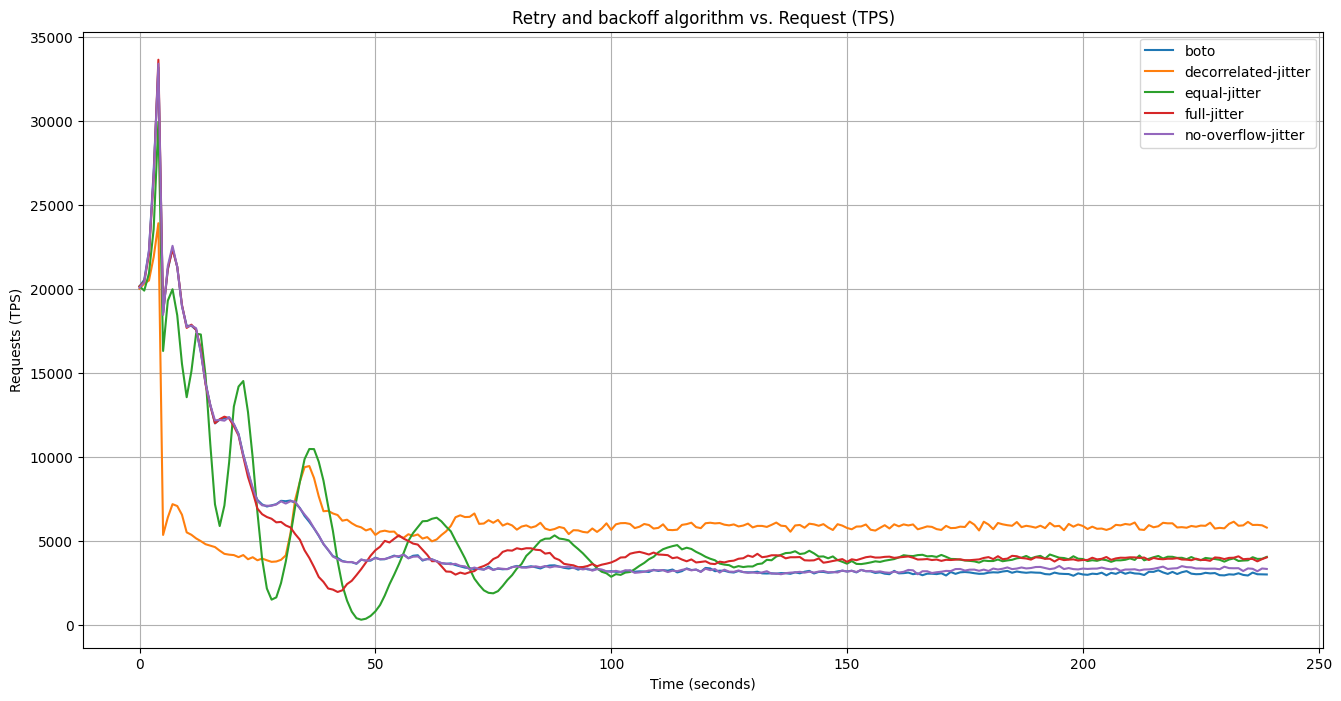

In [5]:
df = pd.DataFrame(results)
plot = df.plot(figsize=(16, 8), grid=True)
plot.set_ylabel("Requests (TPS)")
plot.set_xlabel("Time (seconds)")
plot.set_title("Retry and backoff algorithm vs. Request (TPS)")
None

From the chart above, we can see that each algorithm has different performance characteristics.
Note that the `boto` algorithm performs the best. Unfortunately, this algorithm can cause an integer
overflow exception if the worker retries for an extended time.

```
2023-08-09 06:34:07,647 INFO [deadline_worker_agent.aws.deadline] UpdateWorkerSchedule throttled. Retrying in 30 seconds...
2023-08-09 06:34:37,850 ERROR [deadline_worker_agent.scheduler] Exception in WorkerScheduler
Traceback (most recent call last):
  File "/home/agentuser/.venv/lib/python3.9/site-packages/deadline_worker_agent/aws/deadline/__init__.py", line 688, in update_worker_schedule
    response = deadline_client.update_worker_schedule(**request)
  File "/home/agentuser/.venv/lib/python3.9/site-packages/deadline_worker_agent/boto_mock.py", line 126, in update_worker_schedule
    raise _ClientError(
botocore.exceptions.ClientError: An error occurred (ThrottlingException) when calling the UpdateWorkerSchedule operation: Unknown

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/agentuser/.venv/lib/python3.9/site-packages/deadline_worker_agent/scheduler/scheduler.py", line 244, in run
    interval = self._sync(interruptable=True)
  File "/home/agentuser/.venv/lib/python3.9/site-packages/deadline_worker_agent/scheduler/scheduler.py", line 379, in _sync
    response = update_worker_schedule(**request)
  File "/home/agentuser/.venv/lib/python3.9/site-packages/deadline_worker_agent/aws/deadline/__init__.py", line 692, in update_worker_schedule
    delay = backoff.delay_amount(RetryContext(retry))
  File "/home/agentuser/.venv/lib/python3.9/site-packages/botocore/retries/standard.py", line 275, in delay_amount
    self._random() * (self._base ** (context.attempt_number - 1)),
OverflowError: int too large to convert to float
```


Note that `no-overflow-jitter` has
similar performance characteristics. This implementation is not subject to the integer overflow
exception.

Next, lets illustrate the total request load produced by each algorithm:

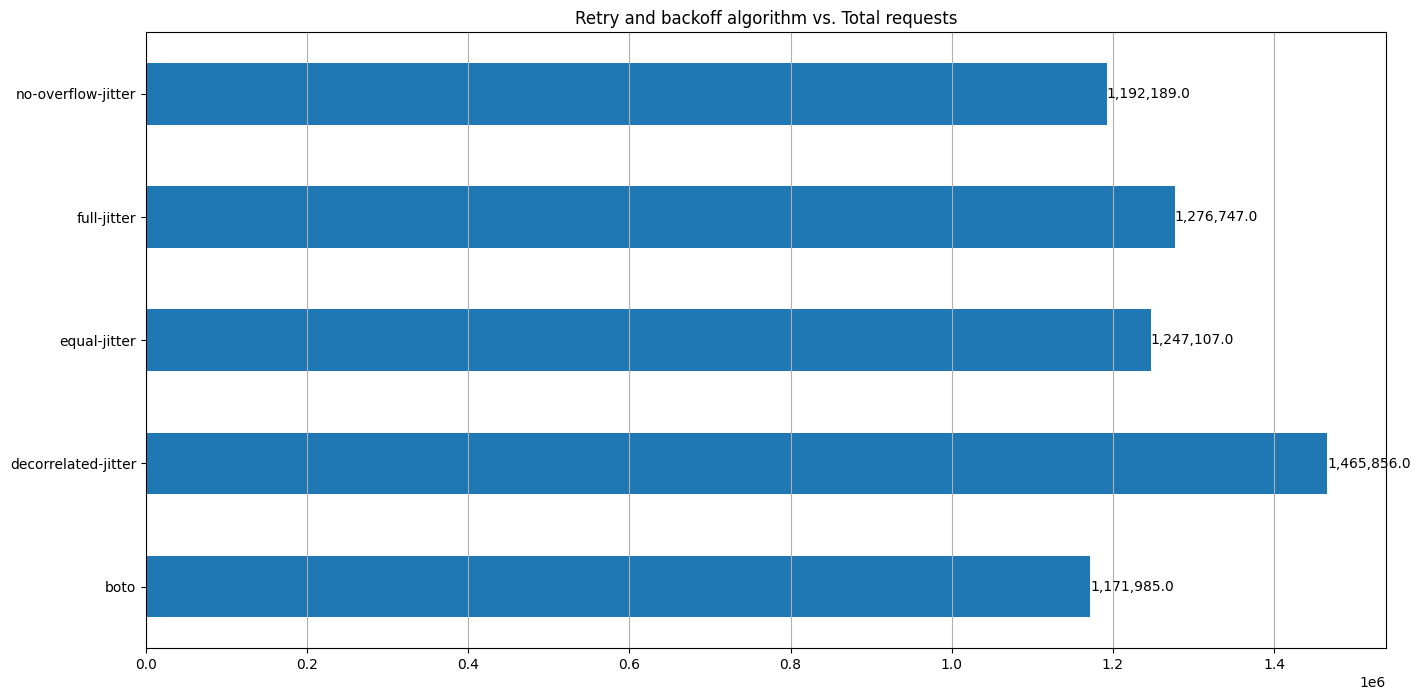

In [6]:
ax = df.sum(axis=0).plot(kind="barh", figsize=(16, 8))
ax.grid(axis="x", which="both")
ax.set_title("Retry and backoff algorithm vs. Total requests")
for container in ax.containers:
    ax.bar_label(container, fmt="{:,}")

## Conclusion

We can see that the `boto` algorithm has the lowest overall number of requests. Since there is the
known overflow issue, the next best algorithm is the `no-overflow-jitter`.